In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats
import scipy

In [3]:
plt.rcParams['figure.figsize'] = [10., 10.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

# Data de-correlation

We first generate some test data in 2d tat are distributed according to a multivariate normal

In [4]:
cov = np.array([[0.07647196, 0.23147416],[0.23147416, 0.98215036]])

In [5]:
X = stats.multivariate_normal([1,1], cov=cov).rvs(10000).T

In [6]:
X.shape

(2, 10000)

In [7]:
def plot(X, *args, **kwargs):
    plt.plot(X[0], X[1], '.', ms=1, *args, **kwargs)
    plt.gca().axvline(0, c='grey')
    plt.gca().axhline(0, c='grey')
    plt.gca().set_xlim(-3,3)
    plt.gca().set_ylim(-3,3)

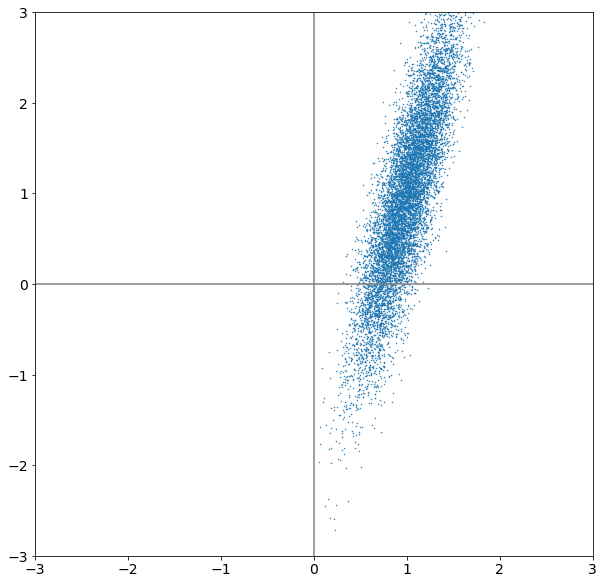

In [8]:
plot(X)
#plt.savefig('X.png', bbox_inches='tight')

## Subtraction of Mean

In [9]:
X = X - np.mean(X, axis=1)[:, np.newaxis]

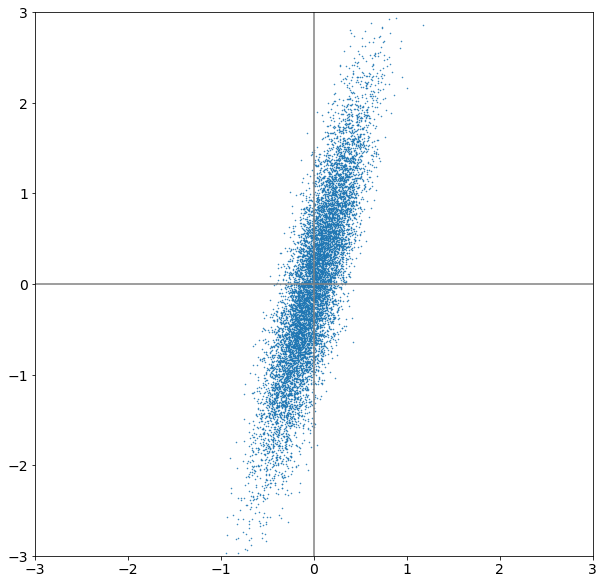

In [10]:
plot(X)
#plt.savefig('X_0.png', bbox_inches='tight')

In this space the sample covariance becomes a very simple expressions:


In [11]:
covX = (X @ X.T) / (X.shape[1] - 1) 
covX

array([[0.07476015, 0.22235869],
       [0.22235869, 0.93850634]])

# Eigenvalue decomposition

We can use scipy's eigenvalue solver to to get the eigenvalues and eigenvectors. Using those we can define our transform `W`

In [12]:
L, E = scipy.linalg.eig(covX)
W = E.T
Y = W @ X

The tranformed sample `Y` is not nicely de-correlated

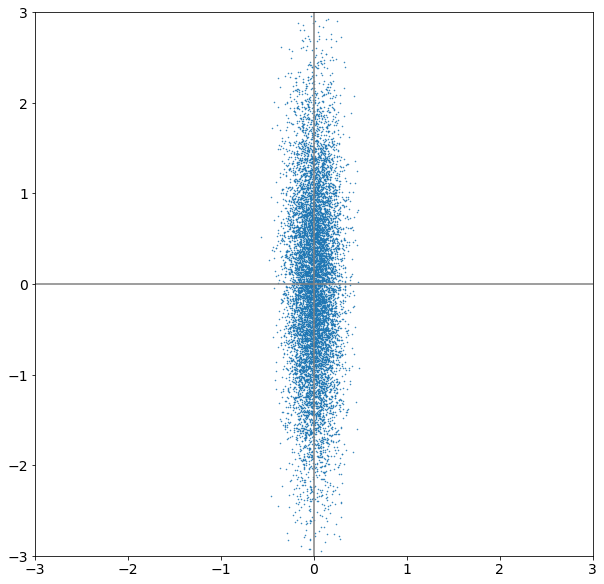

In [13]:
plot(Y)
#plt.savefig('Y_eigen.png', bbox_inches='tight')

We can further whiten the sample by sacling with the eigenvalues

In [14]:
s = 1/np.sqrt(L.real)

In [15]:
Y_eigen = (W @ X) * s[:, np.newaxis]

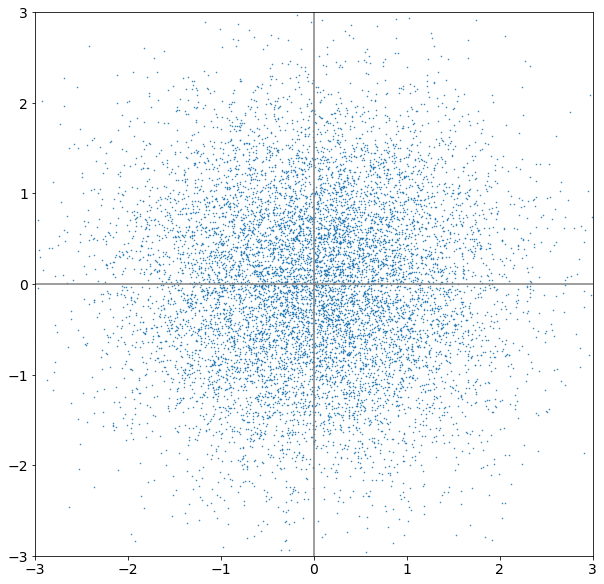

In [16]:
plot(Y_eigen)
#plt.savefig('Y_eigen_white.png', bbox_inches='tight')

The resulting covariance is indeed the identity (up to nummeric imprecisions)

In [17]:
np.cov(Y_eigen)

array([[ 1.00000000e+00, -3.20930956e-16],
       [-3.20930956e-16,  1.00000000e+00]])

# Cholesky

Another way to achieve basically the same is via Cholesky decomposition:

In [18]:
inv_covX = np.linalg.inv(covX)
L = np.linalg.cholesky(inv_covX)
W = L.T
Y_cholesky = W @ X

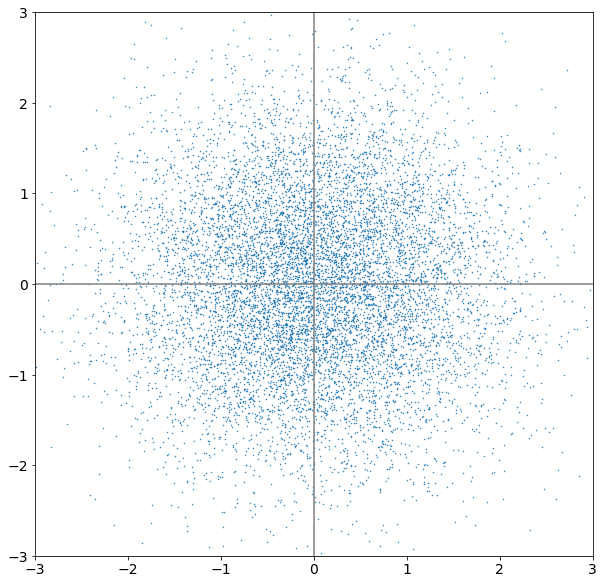

In [19]:
plot(Y_cholesky)
#plt.savefig('Y_cholesky.png', bbox_inches='tight')

In [20]:
np.cov(Y_cholesky)

array([[1.00000000e+00, 6.45770288e-17],
       [6.45770288e-17, 1.00000000e+00]])

# SVD

Or via Singular value Decomposition:

In [21]:
U, s, V = np.linalg.svd(X.T)

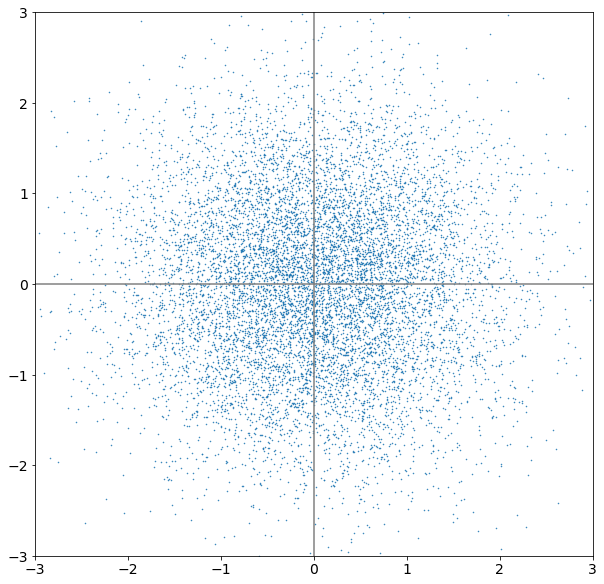

In [22]:
Y_svd = ((V @ X).T @ np.diag(1/s *np.sqrt(X.shape[1] -1))).T
plot(Y_svd)

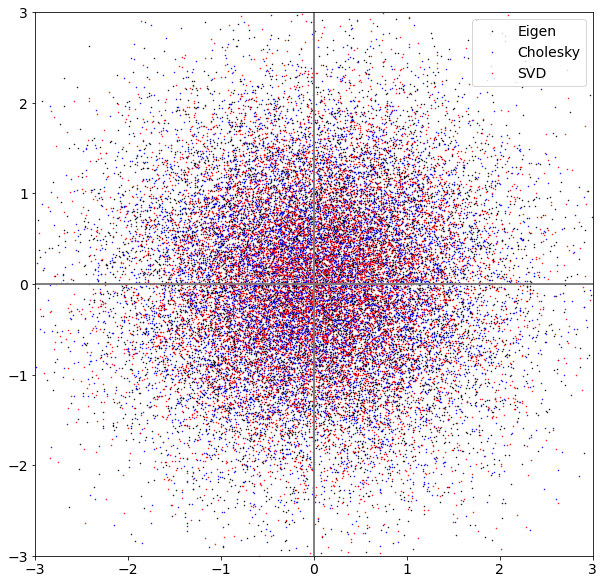

In [23]:
plot(Y_eigen, c='k', label='Eigen')
plot(Y_cholesky, c='b', label='Cholesky')
plot(Y_svd, c='r', label='SVD')
plt.legend()
#plt.savefig('Y_comp.png', bbox_inches='tight')

# Principal Component Analysis

Let's use our SVD to reduce our 2d data to 1d. The component we want to "zero out" is the one with the small variance (the red one in the below plot)

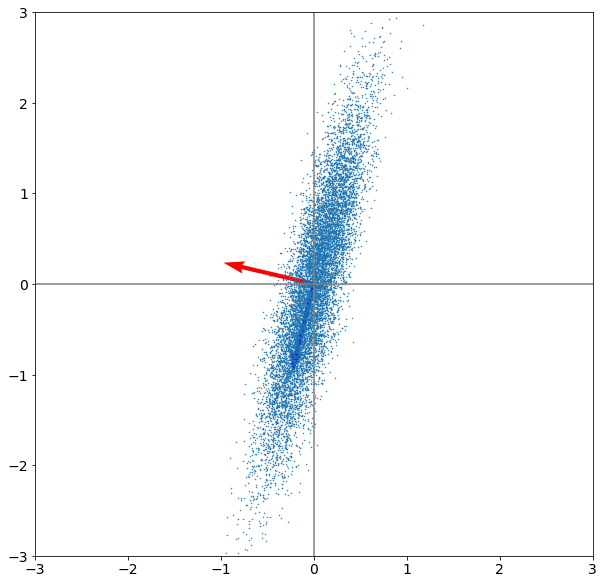

In [24]:
def vec(vec1, color='b'): 
    array = np.array([[0, 0, vec1[0], vec1[1]]])
    x, y, u, v = zip(*array)
    ax = plt.gca()
    ax.quiver(x, y, u, v, color=color, angles='xy', scale_units='xy',scale=1)

plot(X)
vec(V[0])
vec(V[1], "r")
#plt.savefig('X_SVD.png', bbox_inches='tight')

In [25]:
# just for convenience turn s into a matrix S

S = np.zeros((U.shape[0], V.shape[0]))
np.fill_diagonal(S, s)

In [26]:
# this by the way is the sample covariance
V @ (np.square(S) / (X.shape[1] - 1) @ V.T)[:2]

# and this the recosntructed data X from the SVD
Xrec = (U @ S @ V).T

Let us now only use the first component (here indexed with `[0]`), and we can see that we successfully "removed" the small variance. The reconstrcuted sample from the 1d PCA back in the original space now is still 1d, but has most of the information of the original sample

In [27]:
X_pca0 = (U @ S)[:, [0]] @ V[[0]]

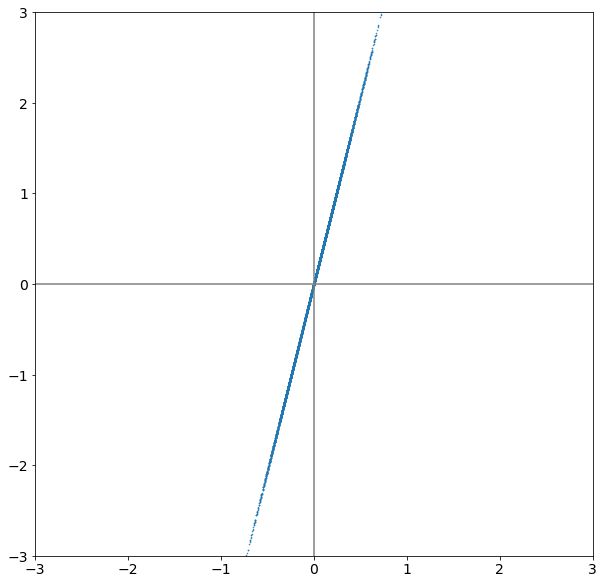

In [28]:
plot(X_pca0.T)
#plt.savefig('pca0', bbox_inches='tight')

# MNIST PCA

Let's explore the MNSIT dataset and use PCA to reduce its dimensionality

In [29]:
# Those are the wrong ones: from sklearn.datasets import load_digits

In [30]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.datasets import fetch_openml

In [ ]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
y = np.int32(y)

In [34]:
def plot(X):
    fig, ax = plt.subplots(5,5)
    for i in range(25):
        axis = ax[i//5, i%5]
        axis.imshow(X[i].reshape(28,28), cmap='gray_r')

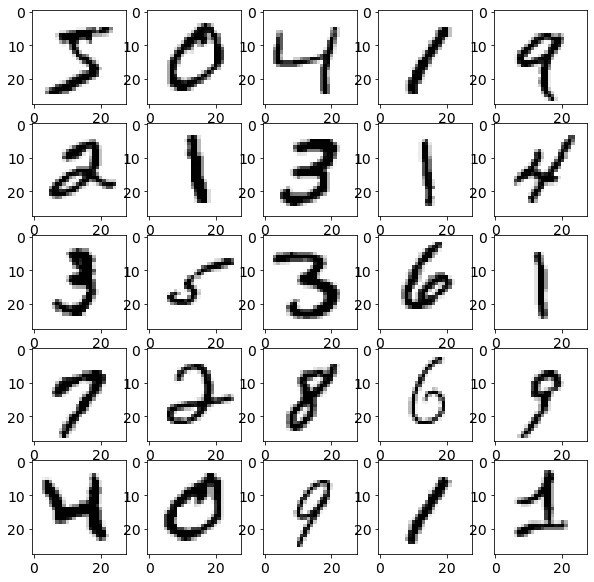

In [35]:
plot(X)
#plt.savefig('mnist.png', bbox_inches='tight')

We will use the PCA functionality provided by `sklearn`, but it is a nice exercise to do it by hand as above! (Be ware that the samples can be singular!)
Here let's do 20 components (See what happens for other numbers!).

In [36]:
p = PCA(n_components=20)
p.fit_transform(X)

array([[ 122.25525496, -316.23384472,  -51.13177482, ...,  295.64919173,
         273.59967767,  139.13859072],
       [1010.4940025 , -289.963622  ,  576.12075694, ...,   37.98910595,
          62.80566695, -119.78963052],
       [ -58.99594684,  393.69744733, -161.99813891, ..., -119.26811994,
         -20.91197232, -434.03297506],
       ...,
       [-271.50701288,  590.07849206,  341.36890976, ...,   40.87036893,
          84.66344587,  -77.15535423],
       [-310.22482133, -116.72715223,  635.71999583, ...,   93.24007713,
        -283.49700455, -196.5657892 ],
       [1058.86212426,  -83.39255749,  731.34221711, ..., -311.39456055,
          -3.80756357,  151.20917859]])

A good measure of how much detail of the original sample is preserved is the "explained variance". here we see that it is arounf 65-70% using only 20 dimensions to reduce our 784d data!

Text(0.5, 0, 'PCA component')

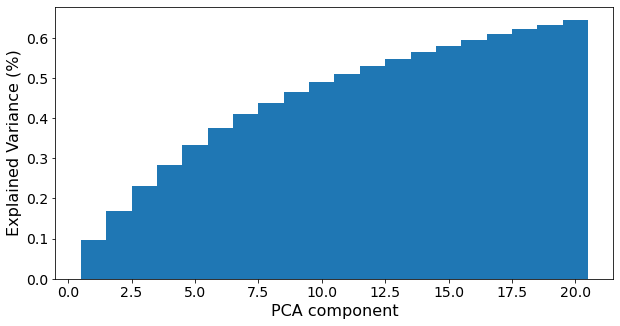

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.bar(np.arange(p.n_components)+1, np.cumsum(p.explained_variance_ratio_), width=1, label='cumulative')
#plt.bar(np.arange(p.n_components)+1, p.explained_variance_ratio_, width=1, label='per component')

ax.set_ylabel('Explained Variance (%)')
ax.set_xlabel('PCA component')

#plt.savefig('explained variance.png', bbox_inches='tight')

We can now use our PCA to apply it to the data, and also recosntrcut it in the original space again. They are quite clearly readable despite only using 20d

In [38]:
reduced_data = p.transform(X)

In [39]:
digits_rec = p.inverse_transform(reduced_data)

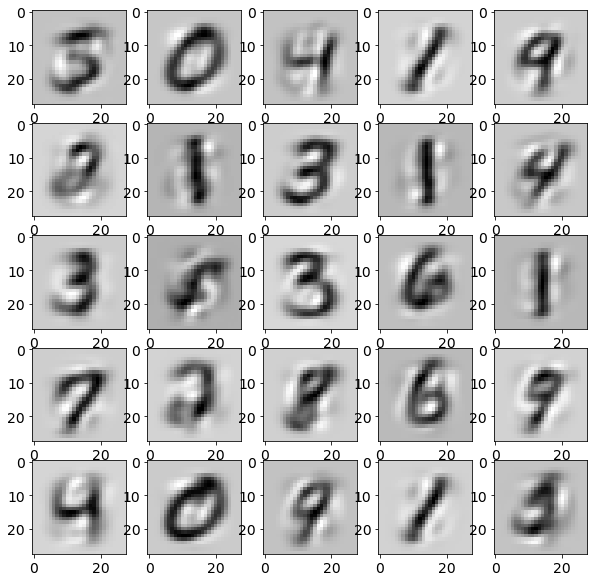

In [40]:
plot(digits_rec)

This is how the first two componetns are distributed

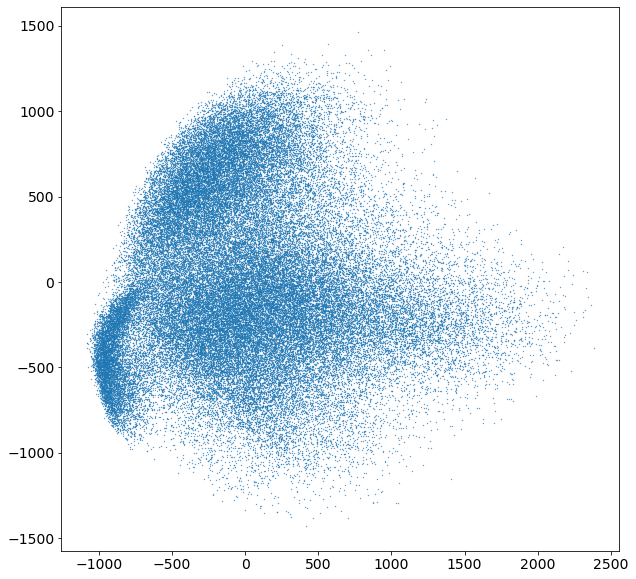

In [41]:
plt_data = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=0.1)

## De-correlation of MNSIT "by hand" example

Just for completness sake, let's see how we could go about doing an eigenvalue decomposition of MNIST ourselevs.
Since data is 784 dimensional, we will just look at the correlation matrix as an image (see below). The regular staructure can be explained by the images pixel ordering.

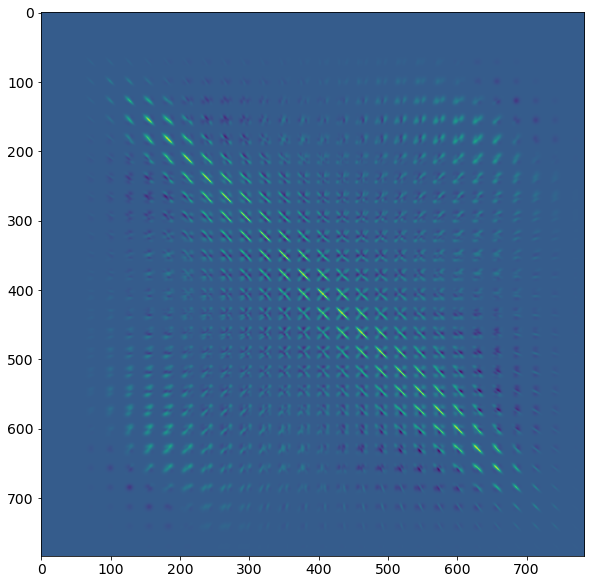

In [43]:
covX = np.cov(X.T)
plt.imshow(covX)

In [44]:
w, v = np.linalg.eig(covX)

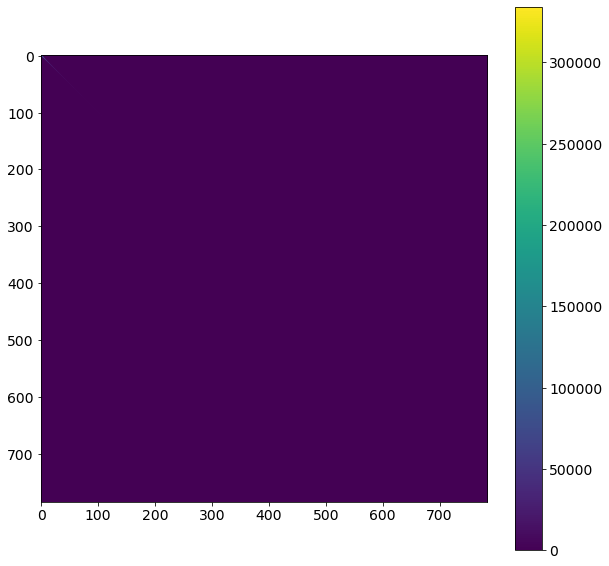

In [51]:
plt.imshow(v.real.T @ covX @ v.real)
plt.colorbar()

Since it is a bit hard to see, we zoom in to the upper left corner, and see that indeed it is diagonal, with descending size

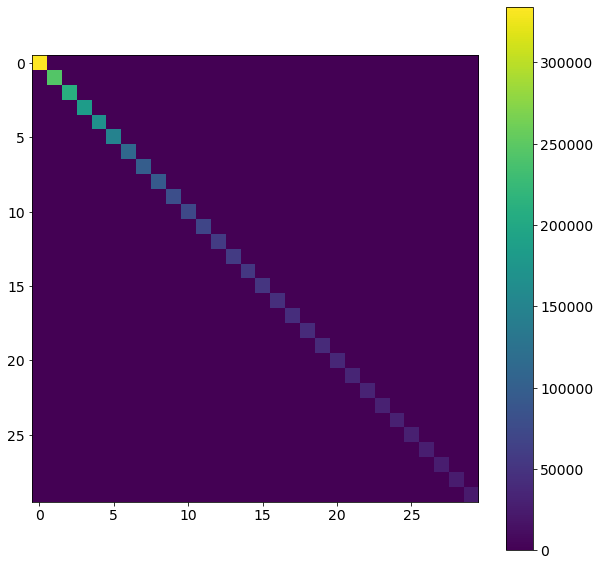

In [52]:
plt.imshow((v.real.T @ covX @ v.real)[:30,:30])
plt.colorbar()